In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [4]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"]

coluna_ordinal_encoder = ["median_income_cat"]

In [5]:
preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
    ],
    remainder="passthrough",
)

In [6]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [7]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [8]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [9]:
target_transformer = PowerTransformer()

regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": target_transformer,
    },
}

In [10]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.010382,0.012095,-0.000081,-77516.042766,-96239.705692,0.022477
1,DummyRegressor,0.007836,0.012611,-0.000146,-75787.787194,-95217.629397,0.020447
2,DummyRegressor,0.0,0.007356,-0.001737,-76753.598961,-96253.253947,0.007356
3,DummyRegressor,0.012248,0.005492,-0.000101,-76837.804811,-95983.885799,0.01774
4,DummyRegressor,0.00874,0.008156,-0.000114,-76617.245449,-96182.764729,0.016896
5,LinearRegression,0.149891,0.017606,0.682162,-39855.690921,-54254.958115,0.167497
6,LinearRegression,0.036652,0.026265,0.66999,-40272.565406,-54695.230224,0.062917
7,LinearRegression,0.064377,0.020196,0.649247,-42178.059246,-56955.988686,0.084573
8,LinearRegression,0.039714,0.018342,0.669873,-40806.492452,-55146.31876,0.058056
9,LinearRegression,0.037754,0.020136,0.669023,-40788.496555,-55331.351171,0.05789


In [11]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.007841,0.009142,-0.000436,-76702.495836,-95975.447913,0.016983
LinearRegression,0.065678,0.020509,0.668059,-40780.260916,-55276.769391,0.086187
LinearRegression_target,0.06753,0.01795,0.671185,-38909.258354,-55011.704371,0.085479


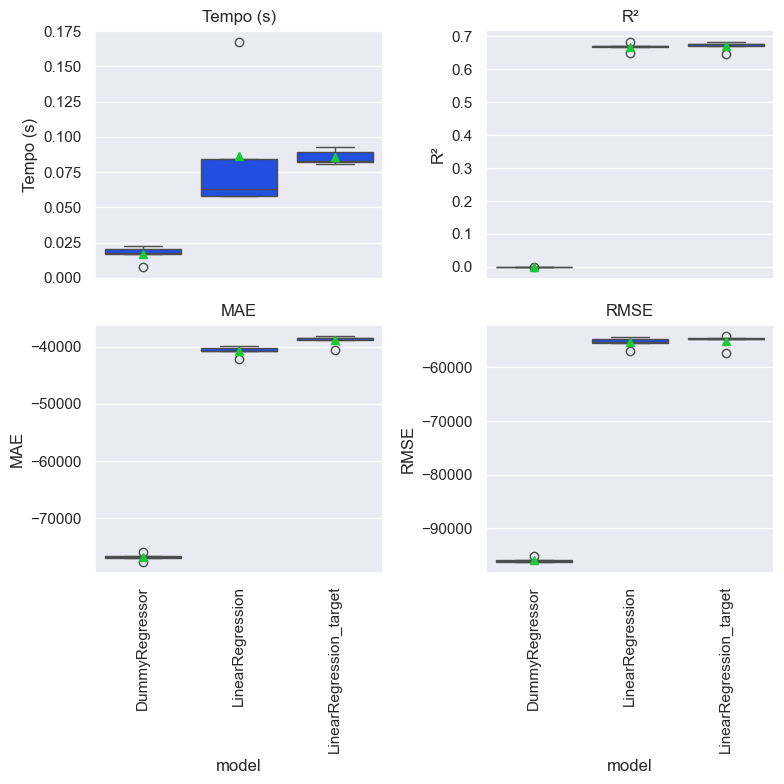

In [12]:
plot_comparar_metricas_modelos(df_resultados)

In [13]:
param_grid = {
    "transformer": [None, PowerTransformer(), QuantileTransformer(output_distribution="normal")]
}

In [14]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento,
    target_transformer=target_transformer,
    param_grid=param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [15]:
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [16]:
grid_search.best_params_

{'transformer': QuantileTransformer(output_distribution='normal')}

In [17]:
grid_search.best_score_

np.float64(-54430.2816334491)

In [18]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
one_hot__ocean_proximity_INLAND,-0.455474
remainder__longitude,-0.294738
remainder__latitude,-0.288061
remainder__population_per_household,-0.280922
one_hot__ocean_proximity_NEAR BAY,-0.203074
one_hot__ocean_proximity_NEAR OCEAN,-0.060721
remainder__total_bedrooms,-0.000227
remainder__total_rooms,-0.000061
remainder__population,-0.000034
remainder__households,0.000854


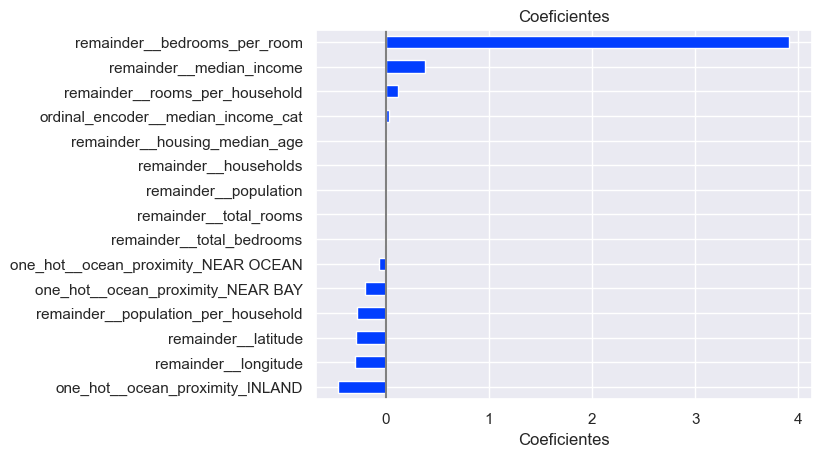

In [19]:
plot_coeficientes(coefs)

In [20]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target_power": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": target_transformer,
    },
    "LinearRegression_target_quantile": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}


resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.012844,0.012012,-0.000081,-77516.042766,-96239.705692,0.024856
1,DummyRegressor,0.004902,0.009542,-0.000146,-75787.787194,-95217.629397,0.014445
2,DummyRegressor,0.005335,0.009075,-0.001737,-76753.598961,-96253.253947,0.01441
3,DummyRegressor,0.00604,0.00805,-0.000101,-76837.804811,-95983.885799,0.01409
4,DummyRegressor,0.006023,0.00803,-0.000114,-76617.245449,-96182.764729,0.014053
5,LinearRegression,0.041433,0.016045,0.682162,-39855.690921,-54254.958115,0.057478
6,LinearRegression,0.034314,0.021836,0.66999,-40272.565406,-54695.230224,0.05615
7,LinearRegression,0.621501,0.020316,0.649247,-42178.059246,-56955.988686,0.641816
8,LinearRegression,0.176638,0.019113,0.669873,-40806.492452,-55146.31876,0.195751
9,LinearRegression,0.034598,0.018288,0.669023,-40788.496555,-55331.351171,0.052886


In [21]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.007029,0.009342,-0.000436,-76702.495836,-95975.447913,0.016371
LinearRegression,0.181697,0.019119,0.668059,-40780.260916,-55276.769391,0.200816
LinearRegression_target_power,0.066961,0.018012,0.671185,-38909.258354,-55011.704371,0.084974
LinearRegression_target_quantile,0.045168,0.017952,0.678168,-38674.477264,-54423.652283,0.06312


In [22]:
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.007029,0.009342,-0.000436,-76702.495836,-95975.447913,0.016371
LinearRegression,0.181697,0.019119,0.668059,-40780.260916,-55276.769391,0.200816
LinearRegression_target_power,0.066961,0.018012,0.671185,-38909.258354,-55011.704371,0.084974
LinearRegression_target_quantile,0.045168,0.017952,0.678168,-38674.477264,-54423.652283,0.06312


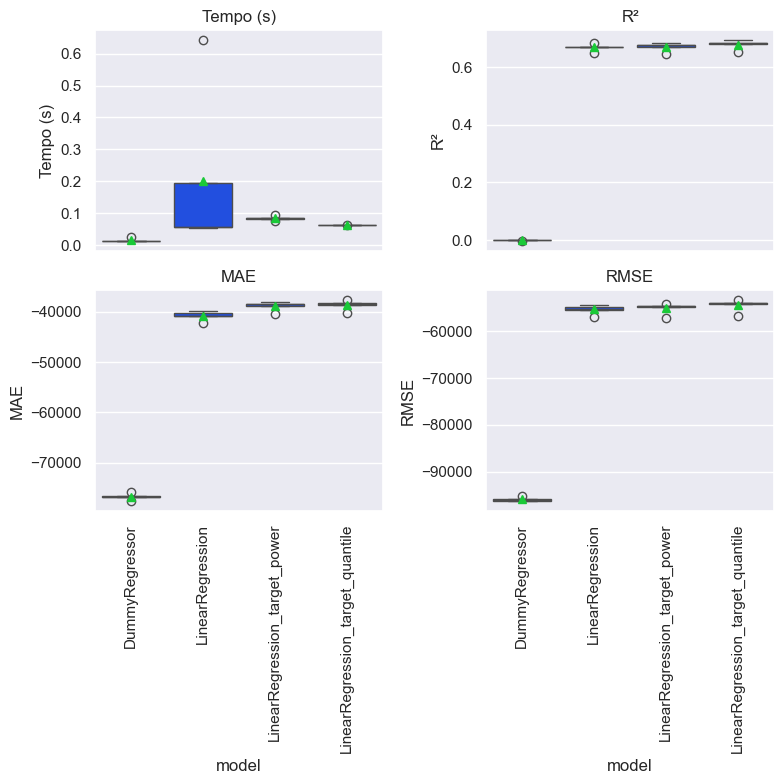

In [23]:
plot_comparar_metricas_modelos(df_resultados)

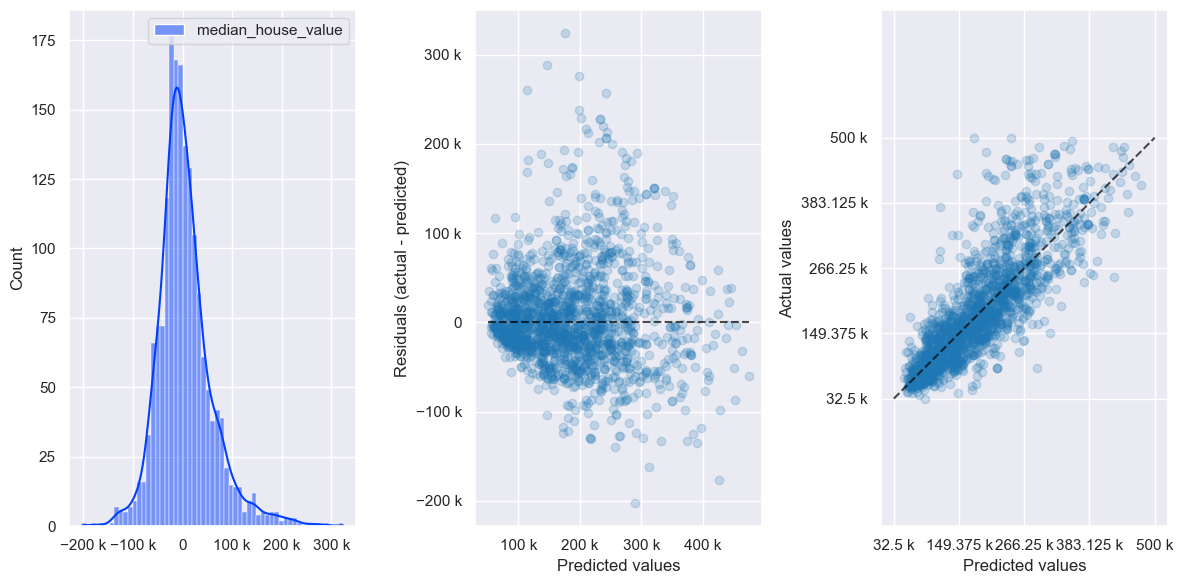

In [24]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)